In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy
import pyreadstat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import os
import random
import warnings
import pyodbc
import time
import os

In [2]:
# Please substitute you path through following lines, these data are available in data folder:

konkors_data_path = 'F:/پایان نامه/First Thesis Archaive/vesal_data/dataset.dta' 
# This dataset is located in the "data" folder, and its name is "dataset" that we call it konkors institute data so far. 

HEIS_data = 'C:\\Users\\NoteBook\\OneDrive\\Desktop\\My_Final_Code\\Data\\Data99.mdb'
# This dataset is located in the "data" folder, and its name is "Data99".

# In this code file, we'll calculate four main moments:
### Section 1 - Moments from konkor's institute.
### Section 2 - Moments from HEIS (1399) data.
### Section 3 - NPV's calculation
### Section 4 - Finding suitable moments to generate error term distribution.

### $\textbf{Section 1 - Moments from konkor's institute.}$
#### A) Average of ability.
#### B) Standard deviation of ability.
#### C) Educational investment share.
#### D) $\underline{b}$ is min required ability.
#### E) Income and Ability share or power in calibration.


In [3]:
dtafile = konkors_data_path
df, meta = pyreadstat.read_dta(dtafile)

In [4]:
print('The average of grade in high school graduated is ' ,round(df['hs_gpa'].mean() , 2 ))
print('The standard deviation of grade in high school graduated is ' ,round(df['hs_gpa'].std(), 2))

The average of grade in high school graduated is  16.09
The standard deviation of grade in high school graduated is  2.35


In [5]:
df = df.fillna(0)
df['hs_gpa'] = df['hs_gpa'].astype(int)             # hs_gpa is high school final exam GPA.
df['pt_session'] = df['pt_session'].astype(int)     # pt_session Private Tutoring (Week Session).
df['cpt_session'] = df['cpt_session'].astype(int)   # cpt_session denote private tutoring for concour (Week Session).
df['trialc'] = df['trialc'].astype(int)             # trialc is participation in trial concour.
df['cbook'] = df['cbook'].astype(int)               # Using Books for Concour.
df['NomrehKoll'] = df['NomrehKoll'].astype(int)     # NomrehKoll refer to total score or 'taraz'.
df['fincome'] = df['fincome'].astype(int)           # fincome is father's income in pervious month.
df['mincome'] = df['mincome'].astype(int)           # mincome is mother's income in prevoius month.
df['rank'] = df['rank'].astype(int)                 # rank is student's rank in their region.

In [6]:
# Keep required variables.
data = df[['mincome', 'fincome' , 'trialc' , 'cbook' , 'cpt_session' ,  'cpt_month' , 'hs_gpa', 'NomrehKoll' , 'rank']]

#### 1 - A) Average of ability

In [7]:
data['hs_gpa'].mean()

15.901204819277108

#### 1 - B) Standard deviation of ability.

In [8]:
print(data['hs_gpa'].std())

2.3014537396308588


#### 1 - C) Educational investment share

In [9]:
data = data.drop(data[data['fincome'] == 0].index) # We dropped all values that have zero or unknwon values.
# data = data[data['cpt_month']< 13] # We can just consider annual income.

# data = data [ data['cpt_session']< 10 ]

 # I delete further data that report they prepare themeselves for kokkur more than 3 years.



#### Generate rand number for differnt income deciles - Father's side:
#### Konkor's data report father's and mother's income by five level:
#### 1 refer to 0 and 750 (thosands toman)
#### 2 refer to 750 and 1500 (thosands toman)
#### 3 refer to 1500 and 3000 (thosands toman)
#### 4 refer to 3000 and 5000 (thosands toman)
#### 5 refer to 5000 and 15000 (thosands toman)
#### to generate these valus we used randint that produce rand numbers between 
rand_list = [] 
random.seed(123)
for i in data['fincome']:
    if i ==1 : rand_list.append(random.randint(0 , 750000))
    elif i== 2: rand_list.append(random.randint(750000 , 1500000))
    elif i == 3: rand_list.append(random.randint(1500000 , 3000000))
    elif i == 4: rand_list.append(random.randint(3000000 , 5000000))
    else: rand_list.append(random.randint(5000000, 15000000))
data['f_inc'] = rand_list


In [10]:

#### We generate these random values for mother's income side again.
rand_list = []   
random.seed(123)
for i in data['mincome']:
    if i == 0 : rand_list.append(0)
    elif i ==1 : rand_list.append(random.randint(0 , 750000))
    elif i== 2: rand_list.append(random.randint(750000 , 1500000))
    elif i == 3: rand_list.append(random.randint(1500000 , 3000000))
    elif i == 4: rand_list.append(random.randint(3000000 , 5000000))
    else: rand_list.append(random.randint(5000000, 15000000))
data['m_inc'] = rand_list

### As we told in first section, Income was reported by month - (specifically for previous month.)
### so we assume these incomes are maintain in their past year and considering them as yearly income.
data['total_income'] = (data['f_inc'] + data['m_inc'])*12

### Vesal and Tavakoli (1397) gatherhed price index of trialc, cbook and cpt_price. Following blocks give us annual educational expenditure of households by multiple service amount and their price.
trialc_price = []
for i in data['trialc']:
    if i == 0 : trialc_price.append(0)
    elif i == 1: trialc_price.append(135000)
    elif i == 2 : trialc_price.append(570000)
    elif i == 3 : trialc_price.append(850000)
data['trialc_price'] = trialc_price


cbook_price = []
for i in data['cbook']:
    if i == 0: cbook_price.append(0)
    elif i == 1: cbook_price.append(90000)
    elif i == 2: cbook_price.append(300000)
data['cbook_price'] = cbook_price

data['cpt_price'] = data['cpt_month'] * (data['cpt_session']*4) *40000
# Finally by adding up cpt_price, trialc_price and cbook_price we can calculate educational investment of household and educational .
data['Edu_inv'] = data['cpt_price'] + data['trialc_price'] + data['cbook_price']

### Here we determine income's quantile of people and divide them to five level.
highest_income =data[data['total_income']>= data['total_income'].quantile(0.8)]
upper_middle_income = data[(data['total_income'] >= data['total_income'].quantile(0.6)) & (data['total_income'] < data['total_income'].quantile(0.8))]# highest_income =data[data['total_income']>= data['total_income'].quantile(0.8)]
middle_income = data[(data['total_income'] >= data['total_income'].quantile(0.4)) & (data['total_income'] < data['total_income'].quantile(0.6))] # highest_income =data[data['total_income']>= data['total_income'].quantile(0.8)]
lower_middle_income = data[(data['total_income'] >= data['total_income'].quantile(0.2)) & (data['total_income'] < data['total_income'].quantile(0.4))]# highest_income =data[data['total_income']>= data['total_income'].quantile(0.8)]
lowest_income =data[data['total_income'] < data['total_income'].quantile(0.2)]

## Educational Investment share:
print('Educational investment for 5th income quantile is', round((highest_income['Edu_inv'].sum()/ highest_income['total_income'].sum()).mean(),3), '.')
print('Educational investment for 4th income quantile is', round((upper_middle_income['Edu_inv'].sum()/ upper_middle_income['total_income'].sum()).mean(),3) , '.')
print('Educational investment for 3th income quantile is', round((middle_income['Edu_inv'].sum()/ middle_income['total_income'].sum()).mean(),3 ) , '.')
print('Educational investment for 2th income quantile is', round((lower_middle_income['Edu_inv'].sum()/ lower_middle_income['total_income'].sum()).mean(),3 ) , '.')
print('Educational investment for 1th income quantile is', round((lowest_income['Edu_inv'].sum()/ lowest_income['total_income'].sum()).mean(),3), '.')

Educational investment for 5th income quantile is 0.027 .
Educational investment for 4th income quantile is 0.034 .
Educational investment for 3th income quantile is 0.045 .
Educational investment for 2th income quantile is 0.055 .
Educational investment for 1th income quantile is 0.084 .


#### 1-D) Correlation between income and ability:

In [11]:
print('Correlation between income and ability is:',round(data['hs_gpa'].corr(data['total_income']),2))

Correlation between income and ability is: 0.16


#### 1 - E) $\underline{b}$ refer to min ability required.

In [12]:
print('Minimum GPA for third grade graduates (based on konkor\'s institute data) is',data['hs_gpa'].min())
print('Maximum GPA for third grade graduates (based on konkor\'s institute data) is',data['hs_gpa'].max())


Minimum GPA for third grade graduates (based on konkor's institute data) is 10
Maximum GPA for third grade graduates (based on konkor's institute data) is 20


In [13]:
# I build dictionary that contain every grade of hs_gpa. 
# Konkor's data has integer values and people's gpa reported by i.e. 10, 11, ... .
dfs = {f'df_{i}': data[data['hs_gpa']==i] for i in range(10, 21)}


In [14]:
### We consider cbook_price (books are most popular tool between konkor's participants) as our measure to find min ability requirement
### So we'll run regression for every gpa grades. those point that higher cbook can't improve studends NomrehKoll it's our measure for b_bar.
### Regression for 10 gpa decile:
y = dfs['df_10']['NomrehKoll']
X = dfs['df_10']['cbook_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             NomrehKoll   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.033
Date:                Tue, 14 Nov 2023   Prob (F-statistic):              0.157
Time:                        20:22:12   Log-Likelihood:                -882.11
No. Observations:                 105   AIC:                             1768.
Df Residuals:                     103   BIC:                             1774.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5183.7716    151.789     34.151      

In [15]:
### Regression for 11 gpa decile:
y = dfs['df_11']['NomrehKoll']
X = dfs['df_11']['cbook_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
print('As we see, it\'s not significant result and people with higher expenditure over books, can\'t earn better score')

                            OLS Regression Results                            
Dep. Variable:             NomrehKoll   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     4.982
Date:                Tue, 14 Nov 2023   Prob (F-statistic):             0.0282
Time:                        20:22:12   Log-Likelihood:                -743.96
No. Observations:                  88   AIC:                             1492.
Df Residuals:                      86   BIC:                             1497.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5171.2253    178.717     28.935      

In [16]:
### Regression for 12 gpa decile:
y = dfs['df_12']['NomrehKoll']
X = dfs['df_12']['cbook_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             NomrehKoll   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     6.045
Date:                Tue, 14 Nov 2023   Prob (F-statistic):             0.0149
Time:                        20:22:12   Log-Likelihood:                -1580.9
No. Observations:                 187   AIC:                             3166.
Df Residuals:                     185   BIC:                             3172.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5214.8042    121.615     42.880      

In [17]:
### Regression for 13 gpa decile:
y = dfs['df_13']['NomrehKoll']
X = dfs['df_13']['cbook_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             NomrehKoll   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     25.66
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           9.25e-07
Time:                        20:22:12   Log-Likelihood:                -1705.6
No. Observations:                 202   AIC:                             3415.
Df Residuals:                     200   BIC:                             3422.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5402.3005    119.603     45.169      

In [18]:
### Regression for 14 gpa decile:
y = dfs['df_14']['NomrehKoll']
X = dfs['df_14']['cbook_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             NomrehKoll   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     36.17
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           4.33e-09
Time:                        20:22:12   Log-Likelihood:                -3188.4
No. Observations:                 374   AIC:                             6381.
Df Residuals:                     372   BIC:                             6389.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5517.1209     96.930     56.919      

In [19]:
### Regression for 15 gpa decile:
y = dfs['df_15']['NomrehKoll']
X = dfs['df_15']['cbook_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             NomrehKoll   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     51.24
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           3.12e-12
Time:                        20:22:12   Log-Likelihood:                -4076.2
No. Observations:                 478   AIC:                             8156.
Df Residuals:                     476   BIC:                             8165.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5908.0992     89.880     65.733      

In [20]:
### Regression for 16 gpa decile:
y = dfs['df_16']['NomrehKoll']
X = dfs['df_16']['cbook_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             NomrehKoll   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     50.76
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           2.93e-12
Time:                        20:22:12   Log-Likelihood:                -5321.4
No. Observations:                 618   AIC:                         1.065e+04
Df Residuals:                     616   BIC:                         1.066e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6229.6927     87.350     71.319      

In [21]:
### Regression for 17 gpa decile:
y = dfs['df_17']['NomrehKoll']
X = dfs['df_17']['cbook_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             NomrehKoll   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     58.11
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           7.19e-14
Time:                        20:22:12   Log-Likelihood:                -6693.2
No. Observations:                 782   AIC:                         1.339e+04
Df Residuals:                     780   BIC:                         1.340e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6757.3692     82.850     81.562      

In [22]:
### Regression for 18 gpa decile:
y = dfs['df_18']['NomrehKoll']
X = dfs['df_18']['cbook_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             NomrehKoll   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     91.76
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           1.35e-20
Time:                        20:22:12   Log-Likelihood:                -6496.9
No. Observations:                 761   AIC:                         1.300e+04
Df Residuals:                     759   BIC:                         1.301e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7318.8654     86.605     84.509      

In [23]:
### Regression for 19 gpa decile:
y = dfs['df_19']['NomrehKoll']
X = dfs['df_19']['cbook_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             NomrehKoll   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     64.77
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           5.99e-15
Time:                        20:22:12   Log-Likelihood:                -4321.6
No. Observations:                 510   AIC:                             8647.
Df Residuals:                     508   BIC:                             8656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8343.7686    110.861     75.264      

In [24]:
### Regression for 20 gpa decile:
y = dfs['df_20']['NomrehKoll']
X = dfs['df_20']['cbook_price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

### Regression result for students with 20 grade is insignificant, Because of low number of obs it's negligible. 

                            OLS Regression Results                            
Dep. Variable:             NomrehKoll   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                 -0.089
Method:                 Least Squares   F-statistic:                    0.5115
Date:                Tue, 14 Nov 2023   Prob (F-statistic):              0.506
Time:                        20:22:12   Log-Likelihood:                -56.857
No. Observations:                   7   AIC:                             117.7
Df Residuals:                       5   BIC:                             117.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.016e+04    822.025     12.359      

c:\Users\NoteBook\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


#### 1 - E) Income and Ability share or power in calibration.


In [25]:
## Main calibration code to find alpha and beta values.

tedad  = np.linspace(0, 1, num=1000)   
tedad_new = []
for i in tedad:
    our_round = round(i , 2)
    tedad_new.append(our_round)

lowest_error = 9e+20
b_bar = 10     ### Min ability required that we earned from above section.
beta_inv = 0
alpha_abil = 0
# Because of our assumed taraz functional form, for calibration we just keep our result for grades upper than b_bar.
df1 = data[data['hs_gpa']>=b_bar]
# Our calibration method is find min error between existed NomrehKoll and our simulated taraz.
# We have an important assumption assumption that alpha + beta  = 1
for alpha in tedad_new:
    beta= 1- alpha
    # print(alpha , beta)
    df1['new_taraz'] =b_bar + ((df1['hs_gpa']-b_bar)**alpha * (df1['Edu_inv'])**beta)
    error_Tr = abs(df1['new_taraz'] - df1['NomrehKoll']).sum()
    # We calculate difference between real value of total score (NomrehKoll) and our simulated taraz in each iteration and keep the alpha and beta that minimize our obj function. 
    warnings.filterwarnings("ignore")
    if error_Tr < lowest_error:
        lowest_error = error_Tr
        alpha_abil = alpha
        beta_inv = beta
        df1['final_sim_taraz'] = df1['new_taraz']
# warnings.filterwarnings("ignore")
print('calibration parameter for ability is:' , round(alpha_abil, 2))
print('calibration parameter for investment is:' , round(beta_inv,2))


calibration parameter for ability is: 0.41
calibration parameter for investment is: 0.59


In [26]:
print('Simulated Taraz has average equal to' , df1['final_sim_taraz'].mean(), 'real taraz has average equal:' , df1['NomrehKoll'].mean())
print('Simulated Taraz has standard deviation equal to' , df1['final_sim_taraz'].std(), 'real taraz has standard deviation equal:' , df1['NomrehKoll'].std())


Simulated Taraz has average equal to 5902.040010335523 real taraz has average equal: 7106.245865758755
Simulated Taraz has standard deviation equal to 5246.478198946123 real taraz has standard deviation equal: 1695.2169258804931


### $\textbf{Section 2) Moments from HEIS (1399) data.}$
#### A) Weighted average Income mean.
#### B) Weighted standared deviation of Income.


In [27]:
conn = pyodbc.connect('DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=' +HEIS_data)

sql_query = 'SELECT * FROM U99Data'    # general information about household like weight.
sql_query_1 = 'SELECT * FROM U99P3S01'  # Food's expenditure (Monthly).
sql_query_2 = 'SELECT * FROM U99P3S02'  # Drink's expenditure (Monthly).
sql_query_3 = 'SELECT * FROM U99P3S03'  
sql_query_4 = 'SELECT * FROM U99P3S12'  
# 3 and 4 quries are cloth, shoe, healthcare, transportation, post service, entertaintment, fastfoods and makeup,....(Monthly).

sql_query_5 = 'SELECT * FROM U99P3S04' # House's expenditure like water, electricity ,... (Monthly).
sql_query_6 = 'SELECT * FROM U99P3S13' # Durable goods expenditure like purchasing cement and home repair and ...  (by year).

exp_social = pd.read_sql(sql_query, conn) # people's weight chractristic stored in 'weight'and following refer to data that show us price.
exp_food = pd.read_sql(sql_query_1, conn) # DYCOL06
exp_drink = pd.read_sql(sql_query_2, conn) # DYCOL06
exp_cloth = pd.read_sql(sql_query_3, conn) # DYCOL03
exp_health = pd.read_sql(sql_query_4, conn) # DYCOL03
exp_house = pd.read_sql(sql_query_5, conn) # DYCOL04
exp_durable = pd.read_sql(sql_query_6, conn) #DYCOL05 and DYCOL01


In [28]:
# Change data type to int and rename our favoraite column:

exp_social['weight'] = pd.to_numeric(exp_social['weight'], errors='coerce').fillna(0).astype(int)
exp_food['exp_food'] = pd.to_numeric(exp_food['DYCOL06'], errors='coerce').fillna(0).astype(int)
exp_drink['exp_drink'] = pd.to_numeric(exp_drink['DYCOL06'], errors='coerce').fillna(0).astype(int)
exp_cloth['exp_cloth'] = pd.to_numeric(exp_cloth['DYCOL03'], errors='coerce').fillna(0).astype(int)
exp_health['exp_health'] = pd.to_numeric(exp_health['DYCOL03'], errors='coerce').fillna(0).astype(int)
exp_house['exp_house'] = pd.to_numeric(exp_house['DYCOL04'], errors='coerce').fillna(0).astype(int)
exp_durable['exp_durable'] = pd.to_numeric(exp_durable['DYCOL05'], errors='coerce').fillna(0).astype(int)
exp_durable['code'] = pd.to_numeric(exp_durable['DYCOL01'], errors='coerce').fillna(0).astype(int)

In [29]:
# Yearly expenditure of households (changing to toman):
exp_food = exp_food.groupby('Address').sum()*12/10
exp_drink = exp_drink.groupby('Address').sum()*12/10
exp_cloth = exp_cloth.groupby('Address').sum()*12/10
exp_health = exp_health.groupby('Address').sum()*12/10
exp_house = exp_house.groupby('Address').sum()*12/10
exp_durable['exp_durable'] = exp_durable['exp_durable']/10

# Small number of observations have negative expenditure that we get them out.
exp_house = exp_house[exp_house['exp_house']>=0]
exp_drink = exp_drink[exp_drink['exp_drink']>=0]
exp_cloth = exp_cloth[exp_cloth['exp_cloth']>=0]
exp_health = exp_health[exp_health['exp_health']>=0]
exp_food = exp_food[exp_food['exp_food']>=0]
exp_durable = exp_durable[exp_durable['exp_durable']>=0]
exp_durable_after = exp_durable

In [30]:
exp_durable = exp_durable.groupby('Address').sum()


In [31]:
# Merge all of dataframes together and create total expenditure of households. 
exp_total = pd.merge( exp_cloth , exp_durable , on = 'Address')
exp_total = pd.merge( exp_total , exp_health , on = 'Address')
exp_total = pd.merge( exp_total , exp_food , on = 'Address')
exp_total = pd.merge( exp_total , exp_house , on = 'Address')
exp_total = pd.merge( exp_total , exp_social , on = 'Address')

# create one column that sum up all of expenditures.
exp_total['total_cost'] = exp_total['exp_cloth'] + exp_total['exp_health'] +exp_total['exp_food']+ exp_total['exp_house'] + exp_total['exp_durable'] #+ exp_total['exp_drink']

In [32]:
# We write a function that calculate average expenditure of household with considering peoples weight.
def wei_income(values , weights):
    wei_mean = np.average(values , weights=weight)
    wei_var = np.average((values - wei_mean)**2 , weights= weight)
    return print('Weighted average of income is', wei_mean, 'Weighted sqrt is', np.sqrt(wei_var))



In [33]:
## wei_icnome
expen = exp_total['total_cost'].to_numpy()
weight = exp_total['weight'].to_numpy()

wei_income(values=expen , weights= weight)


Weighted average of income is 59556215.2119475 Weighted sqrt is 41273951.44577053


### $\textbf{Section 3: calculation of College's NPV }$
####

In [34]:
# We define a function that calculate NPV for different level uni attended.
def cal_npv(init_value, growth_rate):
    dis_rate = 0.22 # Discount rate based on average of past 20 years inflation.
    num_years = 30   # Number of year
    npv = 0
    cash_flow = init_value

    for year in range(1, num_years + 1):
        discounted_cash_flow = cash_flow / (1 + dis_rate) ** year
        npv += discounted_cash_flow
        cash_flow *= (1 + growth_rate)

    return npv


##### NPV of A's college level graduated 

In [35]:
### In current and following codes, we put first argument as those level college expenditure and second argument as income growth rate.
print('npv of A\'s college level is', cal_npv(180000000 , 0.23) ,'tomans')

npv of A's college level is 4994868378.815731 tomans


##### NPV of B's college level graduated 

In [36]:
print('npv of B\'s college level is:' , cal_npv(170000000 , 0.225) , 'tomans')

npv of B's college level is: 4438520013.91096 tomans


##### NPV of C's college level graduated 

In [37]:
print('npv of B\'s college level is:',cal_npv(160000000 , 0.215) , 'tomans')

npv of B's college level is: 3709319365.3432913 tomans


##### NPV of D's college level graduated 

In [38]:
print('npv of B\'s college level is:', cal_npv(155000000 , 0.210) , 'tomans')

npv of B's college level is: 3391289739.989186 tomans


##### NPV of A's college level graduated 

In [39]:
print('npv of B\'s college level is:',cal_npv(158000000 , 0.210) , 'tomans')

npv of B's college level is: 3456927605.9244614 tomans


# $\textbf{Section 4: Error Term}$

In [40]:
### This is joint-normal distribution that produce joint normally distribution that has 0.4 correlation between Income and Ability

mean = [15.90,5.95562152119475]
cov= [[2.3**2,1.5188814132043555], [1.5188814132043555,4.127395144577053**2]]
n = 1000
np.random.seed(n)
b,y = np.random.multivariate_normal(mean, cov, n).T
x1_test = b,y

x1_test = pd.DataFrame(x1_test).T
x1_test = x1_test.rename(columns={0: 'Ability', 1: 'Income'})

x1_test['Ability'] = x1_test['Ability'].apply(lambda x:x if x>0 else 0)
x1_test['Income'] = x1_test['Income'].apply(lambda x:x if x>0 else 0)

In [41]:
invest_mapping = {
    0:  0.08,
    1: 0.05,
    2: 0.04,
    3: 0.03,
    4: 0.02,
} # Educational investment as a share of households income.

# Bin the 'Income' column into deciles
x1_test['Decile'] = pd.qcut(x1_test['Income'], 5, labels=False, duplicates='drop')

# Calculate the 'edu_inv1' column using the investment mapping
x1_test['edu_inv1'] = x1_test.apply(lambda row: row['Income'] * invest_mapping[row['Decile']], axis=1)

# Drop the temporary 'Decile' column
x1_test.drop(columns=['Decile'], inplace=True)




In [42]:
# Income and Ability decile code (I write this block to write ability and Income decile over each household and finally use this deciles for heatmap):



income_quantiles = np.quantile(x1_test['Income'], [0.2, 0.4, 0.6, 0.8])
Income_decile = [5 if i >= income_quantiles[3] else 4 if i >= income_quantiles[2] else 3 if i >= income_quantiles[1] else 2 if i >= income_quantiles[0] else 1 for i in x1_test['Income']]

x1_test['Income_decile'] = Income_decile



ability_quantiles = np.quantile(x1_test['Ability'], [0.2, 0.4, 0.6, 0.8])
Ability_decile = [5 if i >= ability_quantiles[3] else 4 if i >= ability_quantiles[2] else 3 if i >= ability_quantiles[1] else 2 if i >= ability_quantiles[0] else 1 for i in x1_test['Ability']]
x1_test['Ability_decile'] = Ability_decile


In [43]:
x_noaid_test = x1_test.copy() # I saved this dataframe for future analysis.

# Epple's utility function
beta = 0.8
def epple(row, quality_utility):
    return (math.log(row['Income'] - row['edu_inv1']+1 ))+ math.log(quality_utility+1)+ beta *math.log( row["Ability"]+1)

In [44]:
quality_utility = {"A":499.4868378815731 , "B":443.852001391096 , "C":370.93193653432913 , "D":339.1289739989186 , "E":345.69276059244614}
mu = 1
sigma = .008
for label in quality_utility.keys():
    noise = np.random.gumbel(mu, sigma , x_noaid_test.shape[0])
    x_noaid_test[f'util_quality_{label}'] = x_noaid_test.apply(lambda x: epple(x, quality_utility[label]), axis=1) + noise 

In [45]:
x_need_aid_test = x1_test.copy()

# Calibration based on calibrated moment:
b_bar = 10
zeta = 0.41
OUR_SAT = []
for i,j in enumerate(x_noaid_test['Ability']):
    if j>= b_bar: OUR_SAT.append(b_bar+ (j-b_bar)**(zeta) * (x_noaid_test.iloc[i]['edu_inv1']**(1-zeta)))
    else:OUR_SAT.append(j)

# x_need_aid_test['OUR_SAT'] =OUR_SAT
x_noaid_test['OUR_SAT'] =OUR_SAT
x_need_aid_test['number'] = list(range(x_need_aid_test.shape[0]))

In [46]:
x_noaid_test = x_noaid_test.sort_values(by = 'OUR_SAT' , ascending= False) # Sort value based on taraz or SAT to priorotize people woth higher taraz.

In [47]:
x_noaid_final_test = x_noaid_test[['util_quality_A' , 'util_quality_B' , 'util_quality_C' , 'util_quality_D' , 'util_quality_E']]

In [48]:
x_noaid_final_test = x_noaid_final_test.T

for i,j in enumerate(x_noaid_final_test):
    # print(j)
    x_noaid_final_test[f'rank_{j}'] = x_noaid_final_test[j].rank(ascending = False)    



x_noaid_final_test = x_noaid_final_test.T
# x_noaid_final_test


In [49]:
# Capacity of people attendance in every grade of university.
A_cap = n/5
B_cap = n/5
C_cap = n/5
D_cap = n/5
E_cap = n/5



A_students_people = []
B_students_people = []
C_students_people = []
D_students_people = []
E_students_people = []


In [50]:
###  Assighning people to universities based on their preference_list:

for i,j in enumerate(x_noaid_test.index):
    # print(j)
    preference_list = x_noaid_final_test.loc[f'rank_{j}'].tolist()
    for prefer in preference_list:
        if prefer== 1 and A_cap>=1:
            A_cap -=1
            A_students_people.append(j)
            break  
        elif prefer ==2 and B_cap>=1:
            B_cap -=1
            B_students_people.append(j)
            break        
        elif prefer ==3 and C_cap >=1:
            C_cap -=1
            C_students_people.append(j)
            break
        elif prefer ==4 and D_cap >=1:
            D_cap -=1
            D_students_people.append(j)
            break
        elif prefer ==5 and E_cap >=1:
            E_cap -=1
            E_students_people.append(j)
            break


In [51]:
### Rank or 'Rotbeh' of every student as a number column
number = []
for i in range(len(x_noaid_final_test)):
    number.append(i)
x_noaid_final_test['number'] = number


In [52]:
#### Convert to DataFrame and change name to fit in merge condition.
A_stu = pd.DataFrame(A_students_people)
B_stu = pd.DataFrame(B_students_people)
C_stu = pd.DataFrame(C_students_people)
D_stu = pd.DataFrame(D_students_people)
E_stu = pd.DataFrame(E_students_people)



A_stu = A_stu.rename(columns={0: 'number'})
B_stu = B_stu.rename(columns={0: 'number'})
C_stu = C_stu.rename(columns={0: 'number'})
D_stu = D_stu.rename(columns={0: 'number'})
E_stu = E_stu.rename(columns={0: 'number'})


In [53]:

A_stu_heat = x_need_aid_test.merge(A_stu, on=  'number')
B_stu_heat = x_need_aid_test.merge(B_stu, on=  'number')
C_stu_heat = x_need_aid_test.merge(C_stu, on=  'number')
D_stu_heat = x_need_aid_test.merge(D_stu, on=  'number')
E_stu_heat = x_need_aid_test.merge(E_stu, on=  'number')

In [54]:
def draw_heat_map(df, label): #define a function to plot hea
    plt.style.use("seaborn")

    #Plot the heatmap
    plt.figure(figsize=(5,5))
    heat_map = sns.heatmap(df, linewidth = 1 , annot = True , cmap="Greens")
    heat_map.set(xlabel='', ylabel='Income decile')
    heat_map.invert_yaxis()
    heat_map.tick_params(labeltop=True, labelbottom=False, top=False)
    plt.title(f"Ability decile {label}")
#     plt.savefig('Geometry Aid consequences A_stu_heat.png', dpi=300 , bbox_inches='tight')

    plt.show()

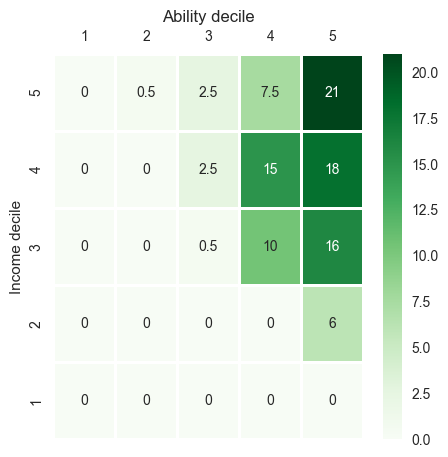

In [55]:
# Build heatmap for cross relation between Income and ability.
# Fake scenario 1
##
gkk = A_stu_heat.groupby(["Income_decile" , "Ability_decile"])['Ability'].count()

##
gkk = gkk.reset_index()

##
dfi = pd.DataFrame({
        'Income_decile' : range(1 , 6)
        })
dfs = pd.DataFrame({
        'Ability_decile' : range(1 , 6)
        })

df = dfi.merge(dfs , how = 'cross')
df

##
df = df.merge(gkk , how = 'left' , on = ['Income_decile' , 'Ability_decile'])

##
df = df.fillna(0)

##
df1 = df.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'Ability')
##
df1 = df1.astype(int)*0.5

plt.style.use("seaborn")


#Plot the heatmap
plt.figure(figsize=(5,5))
heat_map = sns.heatmap( df1, linewidth = 1 , annot = True , cmap="Greens")
heat_map.set(xlabel='', ylabel='Income decile')
heat_map.invert_yaxis()
heat_map.tick_params(labeltop=True, labelbottom=False, top=False)
plt.title("Ability decile")
# plt.savefig('Geometry Aid consequences A_stu_heat.png', dpi=300 , bbox_inches='tight')

plt.show()


In [56]:
### Following blocks clean data to show us different aid for differnt income decile.

level_tuition_A= 1.6
level_tuition_B= .8
level_tuition_C= .7 
level_tuition_D= .5
level_tuition_E= 0

A_stu_heat['Aid'] = level_tuition_A
B_stu_heat['Aid'] = level_tuition_B
C_stu_heat['Aid'] = level_tuition_C
D_stu_heat['Aid'] = level_tuition_D
E_stu_heat['Aid'] = level_tuition_E


In [57]:
population = A_stu_heat.append(B_stu_heat)
population = population.append(C_stu_heat)
population = population.append(D_stu_heat)
population = population.append(E_stu_heat)

Aid Allocation for differnt income deciles: [11.916666666666666, 13.319444444444445, 22.583333333333332, 26.86111111111111, 25.319444444444443]


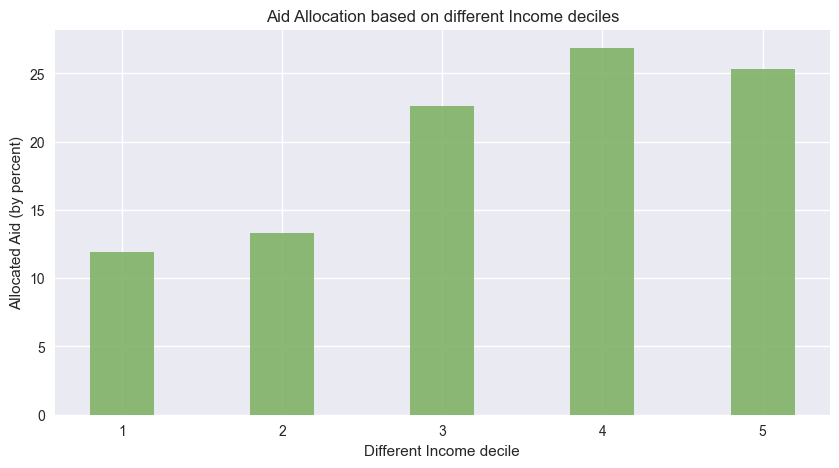

In [58]:

population = population.groupby('Income_decile').sum()

income_list = population.index.to_list()

Aid_list = population['Aid'].to_list() 
Aid_list = [100*i/720  for i in Aid_list]
print('Aid Allocation for differnt income deciles:',Aid_list)

fig = plt.figure(figsize = (10, 5))

color = (0.5, # redness
         0.7, # greenness
         0.4, # blueness
         0.9 # transparency
         ) 
# creating the bar plot
plt.bar(income_list, Aid_list, color =color, 
        width = 0.4)
 
plt.xlabel("Different Income decile")
plt.ylabel("Allocated Aid (by percent)")
plt.title("Aid Allocation based on different Income deciles")
plt.show()

In [59]:
# quality_utility = {"A":499.4868378815731 , "B":443.852001391096 , "C":370.93193653432913 , "D":339.1289739989186 , "E":345.69276059244614}

## Follwing code prepare data to calculate cosumption in zero state condition that tuition paid by governs.
util_qual_A = 499.4868378815731
util_qual_B = 443.852001391096
util_qual_C = 370.93193653432913
util_qual_D = 339.1289739989186
util_qual_E = 345.69276059244614
A_stu_heat['util']= np.log(A_stu_heat['Income'] - A_stu_heat['edu_inv1']+1) + np.log(util_qual_A+1) + beta * np.log(A_stu_heat['Ability']+1)  
B_stu_heat['util']= np.log(B_stu_heat['Income'] - B_stu_heat['edu_inv1']+1) + np.log(util_qual_B+1) + beta * np.log(B_stu_heat['Ability']+1)  
C_stu_heat['util']= np.log(C_stu_heat['Income'] - C_stu_heat['edu_inv1']+1) + np.log(util_qual_C+1) + beta * np.log(C_stu_heat['Ability']+1)  
D_stu_heat['util']= np.log(D_stu_heat['Income'] - D_stu_heat['edu_inv1']+1) + np.log(util_qual_D+1) + beta * np.log(D_stu_heat['Ability']+1)  
E_stu_heat['util']= np.log(E_stu_heat['Income'] - E_stu_heat['edu_inv1']+1) + np.log(util_qual_E+1) + beta * np.log(E_stu_heat['Ability']+1)  

In [60]:
total_util_zerostate = A_stu_heat['util'].sum() + B_stu_heat['util'].sum() + C_stu_heat['util'].sum() + D_stu_heat['util'].sum() + E_stu_heat['util'].sum()
print('Social welfare of people in zerostate is', total_util_zerostate)

Social welfare of people in zerostate is 9943.826152345653


In [61]:
x_noaid_test['cons'] = np.log(x_noaid_test['Income'] - x_noaid_test['edu_inv1'] +1)

In [62]:
x_noaid_test = x_noaid_test.groupby(by='Income_decile').sum()

In [63]:
x_noaid_test['cons'].tolist()  ## Zero state consumption.

[86.87262779843152,
 299.04637915975275,
 379.1056537714724,
 439.35780385687787,
 504.6039861950231]